In [194]:
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dropout , Input , TimeDistributed , Dense , LSTM
from tensorflow.keras.callbacks import TensorBoard
import os

In [195]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [196]:
#Estbalishing connection to the database
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Batch_Data']

In [197]:
#Extracting the data

cursor = collection.find({}) 
batch_df = pd.DataFrame(list(cursor))

In [198]:
batch_df.head()

,_id,landmarks,label
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book


In [199]:
len(batch_df['landmarks'][0])

30

In [200]:
actions = batch_df['label'].unique()

In [201]:
label_map = {label : num for num,label in enumerate(actions)}

In [202]:
label_map

{'book': 0,
 'drink': 1,
 'computer': 2,
 'before': 3,
 'chair': 4,
 'go': 5,
 'clothes': 6,
 'who': 7,
 'candy': 8}

In [159]:

#converting the string values into numeric values

label_encoder = LabelEncoder()
batch_df['label_encoded'] = label_encoder.fit_transform(batch_df['label'])


In [160]:
batch_df

,_id,landmarks,label,label_encoded
0,672af22fe02a1652aab644af,"[{'face': [[0.528167724609375, 0.2578373367231...",book,11
1,672af22fe02a1652aab644b0,"[{'face': [[0.242395827902416, 0.2020864317403...",book,11
2,672af22fe02a1652aab644b1,"[{'face': [[0.4664744738874764, 0.219961448490...",book,11
3,672af22fe02a1652aab644b2,"[{'face': [[0.479362738886966, 0.2433891842543...",book,11
4,672af22fe02a1652aab644b3,"[{'face': [[0.492517174267378, 0.0870498852922...",book,11
...,...,...,...,...
995,672af22fe02a1652aab64892,"[{'face': [[0.41673927693753626, 0.20555076170...",tell,85
996,672af22fe02a1652aab64893,"[{'face': [[0.5213522366115024, 0.215353012084...",tell,85
997,672af22fe02a1652aab64894,"[{'face': [[0.609763869822351, 0.2657764752705...",tell,85
998,672af22fe02a1652aab64895,"[{'face': [[0.45382191153133605, 0.19372511709...",tell,85


Reshaping the Landmarks to align all the landmarks

In [161]:
def reshape_landmarks(record):

 iterations = len(record)
 
 concatenated_one_video = []

 for count in range(iterations):
 
    face_lands = np.array(record[count]['face'])
    left_hand_lands = np.array(record[count]['left_hand'])
    right_hand_lands = np.array(record[count]['right_hand'])

    #Concatinating all the landmarks to the shape (510 , 3)

    all_landmarks = np.vstack([face_lands , left_hand_lands , right_hand_lands]) # concatenated landmarks for 1 frame of the video

    concatenated_one_video.append(all_landmarks)
 
 return np.array(concatenated_one_video)

In [162]:
batch_df['concatenated_landmarks'] = batch_df['landmarks'].progress_apply(reshape_landmarks)

100%|██████████| 1000/1000 [00:13<00:00, 75.81it/s]


In [163]:
batch_df.head(20)

,_id,landmarks,label,label_encoded,concatenated_landmarks
0,672af22fe02a1652aab644af,"[{'face': [[0.528167724609375, 0.2578373367231...",book,11,"[[[0.528167724609375, 0.25783733672313774, -0...."
1,672af22fe02a1652aab644b0,"[{'face': [[0.242395827902416, 0.2020864317403...",book,11,"[[[0.242395827902416, 0.20208643174030372, -0...."
2,672af22fe02a1652aab644b1,"[{'face': [[0.4664744738874764, 0.219961448490...",book,11,"[[[0.4664744738874764, 0.21996144849046956, -0..."
3,672af22fe02a1652aab644b2,"[{'face': [[0.479362738886966, 0.2433891842543...",book,11,"[[[0.479362738886966, 0.2433891842543816, -0.0..."
4,672af22fe02a1652aab644b3,"[{'face': [[0.492517174267378, 0.0870498852922...",book,11,"[[[0.492517174267378, 0.08704988529227371, -0...."
5,672af22fe02a1652aab644b4,"[{'face': [[0.5037075336162861, 0.212660868523...",book,11,"[[[0.5037075336162861, 0.21266086852352922, -0..."
6,672af22fe02a1652aab644b5,"[{'face': [[0.6170888525971184, 0.233574485590...",drink,35,"[[[0.6170888525971184, 0.23357448559033542, -0..."
7,672af22fe02a1652aab644b6,"[{'face': [[0.5804450504815399, 0.244794918634...",drink,35,"[[[0.5804450504815399, 0.24479491863410122, -0..."
8,672af22fe02a1652aab644b7,"[{'face': [[0.697213880098783, 0.2216544588257...",drink,35,"[[[0.697213880098783, 0.22165445882574958, -0...."
9,672af22fe02a1652aab644b8,"[{'face': [[0.4147786676067196, 0.049399815256...",drink,35,"[[[0.4147786676067196, 0.04939981525658852, -0..."


In [169]:
batch_df['concatenated_landmarks'].progress_apply(lambda row : (row).shape )

100%|██████████| 1000/1000 [00:00<00:00, 500334.49it/s]


0      (30, 510, 3)
1      (30, 510, 3)
2      (30, 510, 3)
3      (30, 510, 3)
4      (30, 510, 3)
           ...     
995    (30, 510, 3)
996    (30, 510, 3)
997    (30, 510, 3)
998    (30, 510, 3)
999    (30, 510, 3)
Name: concatenated_landmarks, Length: 1000, dtype: object

In [170]:
batch_df['concatenated_landmarks'][88].shape

(30, 510, 3)

In [171]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(batch_df['label_encoded'])

In [172]:
one_hot_encoded_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Splitting the Data into Train and Test set

In [173]:
X = batch_df['concatenated_landmarks']
Y = one_hot_encoded_labels

# using 75 - 25 train - test split

X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size= 0.25 , shuffle= True , random_state= 42 )

In [174]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

In [175]:
#Re-shaping the landmarks from ( 30 , 510 , 3) to (30 , 510 * 3) as LSTM expects 2D data

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , -1)

In [176]:
X_train.shape

(750, 30, 1530)

In [177]:
type(X_train)

numpy.ndarray

In [178]:
X_train[1  , 1 , 1 ]

0.30509451031684875

In [179]:
print('The Shape of X-Train is:' , X_train.shape)
print('The Shape of X-Test is:' , X_test.shape)
print('The Shape of Y-Train is:' , Y_train.shape)
print('The Shape of Y-Test is:' , Y_test.shape)

The Shape of X-Train is: (750, 30, 1530)
The Shape of X-Test is: (250, 30, 1530)
The Shape of Y-Train is: (750, 99)
The Shape of Y-Test is: (250, 99)


In [180]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Constructing LSTM Model

In [181]:
#Monitoring the accuracy while training

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [182]:
X_train.shape

(750, 30, 1530)

In [183]:
# Constructing LSTM Model

model = Sequential()
model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1530)))
model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
model.add(LSTM(64 , return_sequences= False , activation='relu'))
model.add(Dense(64 , activation ='relu'))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [184]:
res = [0.05 , 0.05 , 0.4 , 0.1 , 0.1 ,0.1 ,0.1 , 0.05 ,0.05]

In [185]:
actions[np.argmax(res)]

'computer'

In [186]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 15 , 
 mode = 'min',
 restore_best_weights = True
)

In [187]:
#Compiling the Model

model.compile(optimizer='Adam' , loss ='categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [188]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │       408,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 99)             │         3,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,051 (2.16 MB)

 Trainable params: 566,051 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
# Fitting the model

model_history = model.fit(X_train , Y_train ,batch_size=50 , epochs = 2000 , callbacks=[tb_callback] , validation_split = 0.2)

Epoch 1/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - categorical_accuracy: 0.0224 - loss: 4.5899 - val_categorical_accuracy: 0.0133 - val_loss: 4.5974
Epoch 2/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - categorical_accuracy: 0.0132 - loss: 4.5883 - val_categorical_accuracy: 0.0133 - val_loss: 4.5955
Epoch 3/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.0174 - loss: 4.5894 - val_categorical_accuracy: 0.0000e+00 - val_loss: 4.6185
Epoch 4/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - categorical_accuracy: 0.0170 - loss: 4.5775 - val_categorical_accuracy: 0.0200 - val_loss: 4.6155
Epoch 5/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - categorical_accuracy: 0.0260 - loss: 4.5819 - val_categorical_accuracy: 0.0133 - val_loss: 4.5837
Epoch 6/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - categorical_accuracy: 0.0273 - loss: 4.5429 - val_categorical_accuracy: 0.0200 - val_loss: 4.5955
Epoch 7/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0

KeyboardInterrupt: 

In [190]:
model.evaluate(X_test , Y_test , verbose = 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.0064 - loss: 4.5950  


[4.597005844116211, 0.004000000189989805]

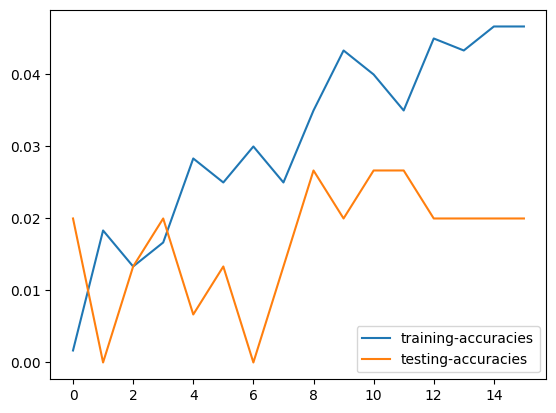

In [192]:
plt.plot(model_history.history['categorical_accuracy'] , label = 'training-accuracies')
plt.plot(model_history.history['val_categorical_accuracy'] , label ='testing-accuracies')
plt.legend(loc = 'lower right')

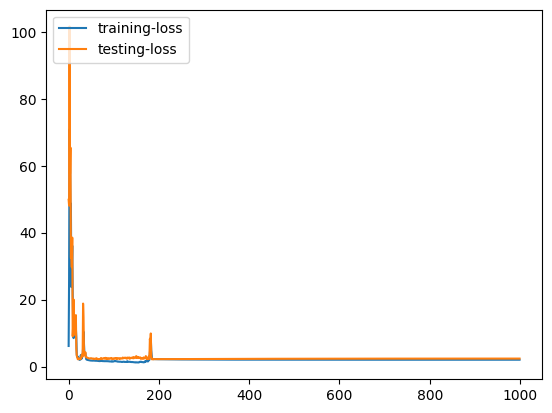

In [ ]:
plt.plot(model_history.history['loss'] , label = 'training-loss')
plt.plot( model_history.history['val_loss'] , label ='testing-loss')
plt.legend(loc = 'upper left')